## 正則化

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression #線形回帰のライブラリ
from sklearn.linear_model import Ridge,Lasso,ElasticNet #正則化項付き最小二乗法を行うためのライブラリ
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

### 正則化とは
多次元の回帰モデルを考える場合、出力に大きく影響する説明変数もあれば、ほとんど影響しない変数もあるはずである。ここで、未知データに強いということは、出力への寄与が小さい影響は無視して、出力への影響が大き良い特徴だけで構成された回帰式だということが想像される。つまり、回帰式中の係数$w$に関して、大きな値を持つものがなるべく小さい方が未知データに対して、頑健な回帰式であるということができる。このように大きな値をとる係数を減らすための工夫を正則化とよぶ。

### データの生成
参考サイト
http://nbviewer.jupyter.org/urls/s3.amazonaws.com/datarobotblog/notebooks/regularized-linear-regression.ipynb

(0, 1)

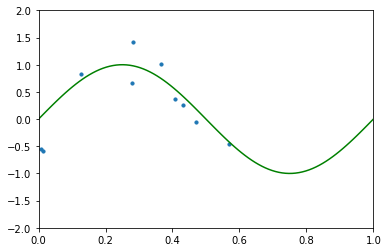

In [2]:
def f(x):
    return np.sin(2 * np.pi * x)

x_plot = np.linspace(0, 1, 100)
n_samples = 10
X = np.random.uniform(0, 1, size=n_samples)[:, np.newaxis]
y = f(X) + np.random.normal(scale=0.3, size=n_samples)[:, np.newaxis]

plt.plot(x_plot, f(x_plot), color='green')
plt.scatter(X, y, s=10)
plt.ylim((-2, 2))
plt.xlim((0, 1))

#### make_pipeline(PolynomialFeatures(degree), LinearRegression())を用いると、多項式回帰モデルを推定することができる。  
#### degreeの違い
degree=0:$y=a_0$  
degree=1:$y=a_0+a_1x$  
degree=3:$y=a_0+a_1x+a_2x^2+a_3x^3$  
degree=9:$y=a_0+\sum_{i=1}^9 {a_ix^i}$  

### 正則化項なしで係数を推定した場合

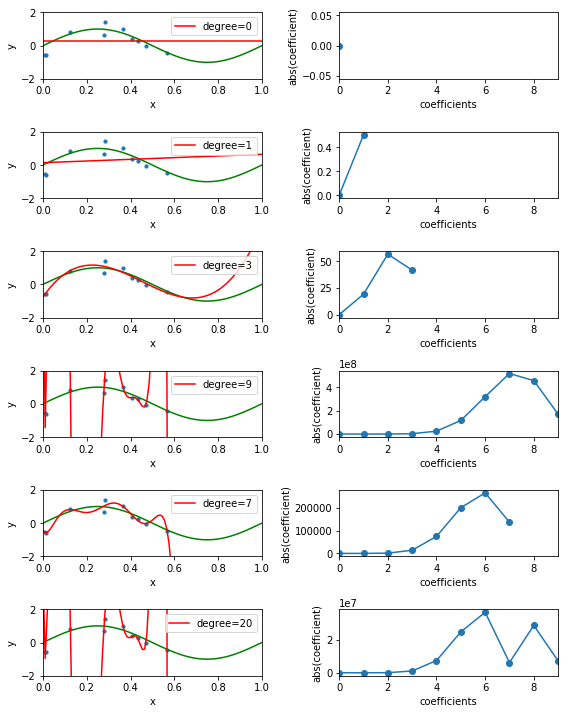

In [7]:
def plot_approximation(est, ax, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), color='green')
    ax.scatter(X, y, s=10)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 1))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right')  #, fontsize='small')

def plot_coefficients(est, ax, label=None, yscale='log'):
    coef = est.steps[-1][1].coef_.ravel()
    if yscale == 'log':
        ax.semilogy(np.abs(coef), marker='o', label=label)
        ax.set_ylim((1e-1, 1e8))
    else:
        ax.plot(np.abs(coef), marker='o', label=label)
    ax.set_ylabel('abs(coefficient)')
    ax.set_xlabel('coefficients')
    ax.set_xlim((0, 9))
    

degrees = [0, 1, 3, 9, 7, 20]#degreeの値を4つ指定する
fig, ax_rows = plt.subplots(len(degrees), 2, figsize=(8, 10))
for ax_row, degree in zip(ax_rows, degrees):
    ax_left, ax_right = ax_row
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(X, y)
    plot_approximation(est, ax_left, label='degree=%d' % degree)
    plot_coefficients(est, ax_right,yscale=None)
    
plt.tight_layout()

- degree=0や1の場合、ほとんど学習データを表現することができていない。これをアンダーフィッティング（未学習）を起こしているという。
- degree=9になると、各係数の値が非常に大きくなっている。係数の値が大きいと、$x$への寄与率が大きくなるということである。既知のデータへの当てはまりは良くなるが、未知のデータ（テストデータ）への当てはまりがわるくなる。これを、オーバーフィッティング（過学習）を起こしているという。

### [演習]
- degree=7の場合はどうなりますか？
- degree=20の場合はどうなりますか？
- データ点数(n_samples)とdegreeの値をいろいろ変えて、結果がどう変わるか確認してみましょう

### 正則化項
最小二乗法は、目的関数$E(w)=\sum_i^n (y_i-y_i')^2$を最小化することが目的であった。正則化項付きの最小二乗法では、  これに正則化項が付いた目的関数を最小化することが目的になる。

- Ridgeは、係数の値が小さくなるように正則化される。
- Lassoは、値を0とする係数が多くなるように正則化される。
- ElasticNetは、RidgeとLassoを組み合わせたものであり、両者のバランスによって性質が決まる。

### 正則化項ありで係数を推定した場合

### Ridge

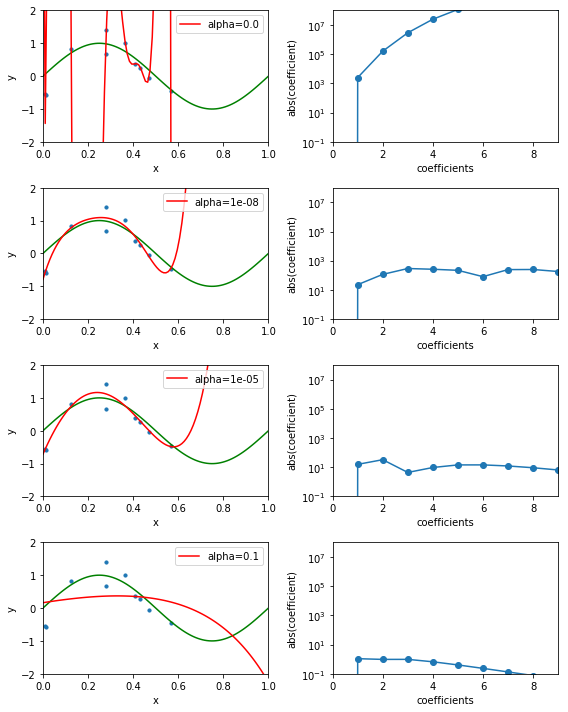

In [8]:
fig, ax_rows = plt.subplots(4, 2, figsize=(8, 10))
degree = 9
alphas = [0.0, 1e-8, 1e-5, 1e-1]#alpha(数式ではλ)の値を4つ指定する
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    # ConvergenceWarning が出るときがあるが、グラフが表示されていれば実行は出来ているので気にしなくて良い
    est = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    est.fit(X, y)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Ridge(alpha=%r) coefficients' % alpha)
plt.tight_layout()

$\alpha$を大きくすると、係数の値が小さくなっていき、過学習が抑制されることがわかる。

### [演習]
- alphaの値をいろいろ変えて、結果がどう変わるか確認してみましょう

### Lasso

/Users/yamaokadaichi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


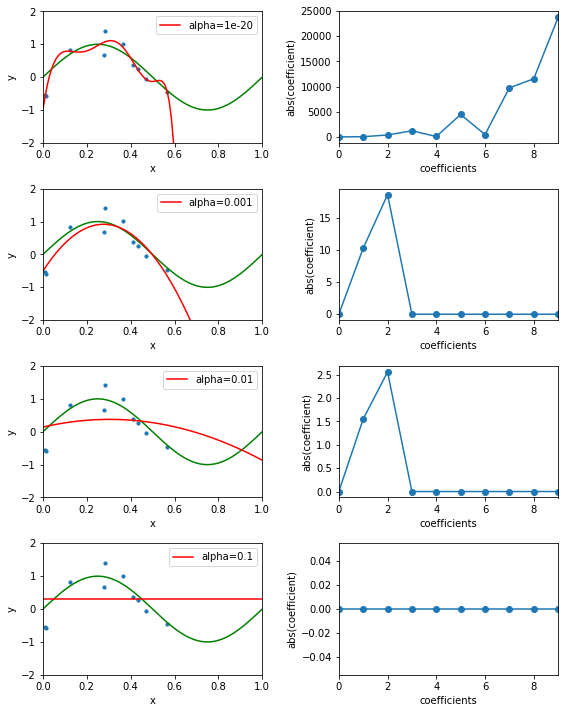

In [9]:
fig, ax_rows = plt.subplots(4, 2, figsize=(8,10))

degree = 9
alphas = [1e-20, 1e-3, 1e-2, 1e-1]#alpha(数式ではλ)の値を4つ指定する
for alpha, ax_row in zip(alphas, ax_rows):
    ax_left, ax_right = ax_row
    # ConvergenceWarning が出るときがあるが、グラフが表示されていれば実行は出来ているので気にしなくて良い
    est = make_pipeline(PolynomialFeatures(degree), Lasso(alpha=alpha,max_iter=1e7))
    est.fit(X, y)
    plot_approximation(est, ax_left, label='alpha=%r' % alpha)
    plot_coefficients(est, ax_right, label='Lasso(alpha=%r) coefficients' % alpha, yscale=None)

plt.tight_layout()

$\alpha$を大きくすると、0の係数が増えていき、過学習が抑制されることがわかる。

### [演習]
- alphaの値をいろいろ変えて、結果がどう変わるか確認してみましょう

### ElasticNet

/Users/yamaokadaichi/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


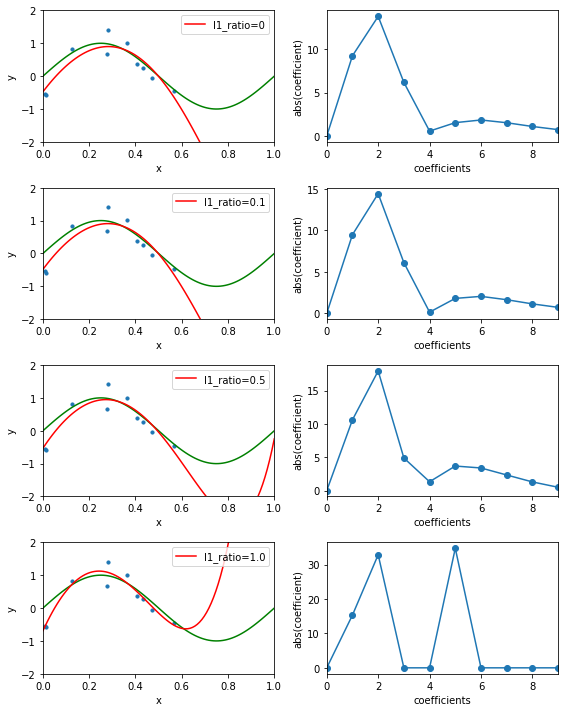

In [10]:
fig, ax_rows = plt.subplots(4, 2, figsize=(8,10))

degree = 20
alpha = 1e-4 #正則化全体の強さを決定する
l1_ratios = [0, 0.1, 0.5, 1.0] #L1正則化の強さを4つ指定する（L2正則化の強さは1 - l1_ratioで自動的に設定される）
for l1_ratio, ax_row in zip(l1_ratios, ax_rows):
    ax_left, ax_right = ax_row
    # ConvergenceWarning が出るときがあるが、グラフが表示されていれば実行は出来ているので気にしなくて良い
    est = make_pipeline(PolynomialFeatures(degree), ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=1e8))
    est.fit(X, y)
    plot_approximation(est, ax_left, label='l1_ratio=%r' % l1_ratio)
    plot_coefficients(est, ax_right, label='ElasticNet(l1_ratio=%r) coefficients' % l1_ratio, yscale=None)

plt.tight_layout()

 - `l1_ratio` が小さければL2正則化の効果が強く現れ，逆に大きければL1正則化の効果が強く現れる

### [演習]
- alphaやl1_ratioの値をいろいろ変えて、結果がどう変わるか確認してみましょう